In [1]:
from pathlib import Path

import yaml
import pandas as pd
import datazimmer as dz
import markdown2

from tqdm.notebook import tqdm

from src.ubermedia import *

- there is a jump in attributes from 0-10 as number between 0 and 10 are discarded (rounded to zero) due to privacy concerns
- 

In [2]:
def get_mdf(month_id):
    traffic_path = dz.get_raw_data_path(f"{month_id}-traffic.parquet")
    att_path = dz.get_raw_data_path(f"{month_id}-atts.parquet")
    if traffic_path.exists():
        tele_df, att_df = map(pd.read_parquet, [traffic_path, att_path])
        return tele_df.join(att_df).join(df.drop(HashHour.year_month, axis=1), how="left").fillna(0)


In [3]:
desc_dic = {}

corr_sers = []

for df in tqdm(h3_table.trepo.dfs):
    month_id = df[HashHour.year_month].iloc[0]
    mdf = get_mdf(month_id)
    if mdf is not None:
        corr_sers.append(
            mdf.assign(miss=lambda df: df["traffic"] - df["count"])
            .pipe(lambda df: df / df[["traffic"]].values)
            .corr()["miss"]
            .drop(["traffic", "count", "miss"])
            .rename(month_id)
        )
        desc_dic[month_id] = (
            mdf.assign(clipped_count=lambda df: df[HashHour.count].clip(0, 10))
            .groupby("clipped_count")["traffic"]
            .describe()
        )
        mdf.to_parquet(dz.get_raw_data_path(f"comparison/{month_id}.parquet"))

0it [00:00, ?it/s]

In [4]:
pd.DataFrame(corr_sers).T.style.background_gradient()

,2020-10,2020-11,2020-06,2020-09,2020-08,2021-02,2021-01,2020-07,2020-12,2021-04,2021-05,2021-03
remainers,0.011933,0.014344,0.005875,0.006346,0.009674,0.017976,0.015756,0.008029,0.014633,0.030043,0.030977,0.025630
loc_home,-0.017303,-0.016690,-0.014310,-0.020253,-0.018918,-0.010168,-0.009013,-0.019890,-0.011268,0.000010,-0.001478,-0.007101
loc_work,-0.001616,-0.000594,-0.004765,-0.004171,-0.005752,0.004209,0.000111,-0.004505,-0.000274,0.007239,0.009984,0.003349
loc_freq,-0.003648,-0.003290,-0.000982,-0.006645,-0.004203,-0.001442,-0.001840,-0.002172,-0.004233,0.010739,0.010514,0.004662
sex_female,0.034557,0.036379,0.030710,0.032090,0.029231,0.039150,0.034499,0.029309,0.035237,0.039480,0.041823,0.036579
sex_male,0.039472,0.041159,0.036763,0.036835,0.033629,0.042416,0.037742,0.034366,0.038790,0.042653,0.045482,0.040396
sex_na,0.049203,0.051355,0.044494,0.046924,0.042638,0.051491,0.046657,0.043208,0.047861,0.049468,0.052881,0.048041
arpu_low,0.037197,0.039504,0.029957,0.034977,0.031631,0.044245,0.038178,0.031739,0.039513,0.041947,0.044342,0.041677
arpu_mid,0.033237,0.036947,0.034403,0.031511,0.027903,0.029344,0.028152,0.029600,0.028397,0.027882,0.029807,0.026976
arpu_high,0.021904,0.022189,0.021274,0.021327,0.021846,0.021676,0.018836,0.021616,0.019882,0.018918,0.020936,0.019145


In [5]:
params = yaml.safe_load(Path("zimmer.yaml").read_text())["envs"]["complete"]["params"]["ubermedia"]

In [6]:
md_lines = [
    "# Comparison with telecommunications data",
    "",
    "tables show descriptive statistics of h3-hour level mobile carrier traffic data "
    "joined to mobility data, grouped by `clipped_count`.",
    "`clipped_count` is clipped at 10, and indicates the unique devices detected in the mobility data "
    "for a given hour-h3 combination.",
    f"a device is only counted if it satisfies the parameters of `{params}` in a given h3-hour combination, "
    "where duration is measured in minutes",
]
html_lines = [markdown2.markdown("\n\n".join(md_lines))]
diffs = []
for k, md_desc in desc_dic.items():
    html_tab = md_desc.style.background_gradient().to_html()
    md_lines.extend([f"## {k}", html_tab])
    html_lines.extend([f"<h2>{k}</h2>", html_tab])
    diffs += md_desc["mean"].diff().dropna().tolist()

In [7]:
md_str = "\n\n".join(md_lines)
Path("reports", "mobility-pattern-comparison.md").write_text(md_str)

157254

In [8]:
Path("reports", "mobility-pattern-comparison.html").write_text("\n".join(html_lines))

157362

In [9]:
pd.concat(v for k, v in desc_dic.items()).groupby("clipped_count").mean()

,count,mean,std,min,25%,50%,75%,max
clipped_count,,,,,,,,
0.0,1.247054e+07,47.352449,58.385822,10.000000,17.083333,28.583333,52.750000,2903.083333
1.0,1.324058e+06,89.576557,102.221787,10.000000,27.166667,53.583333,111.750000,2868.500000
2.0,3.651320e+05,108.366595,122.173180,10.000000,30.916667,66.666667,138.250000,2518.166667
3.0,1.053886e+05,126.878115,142.764770,10.000000,36.583333,80.083333,162.666667,2495.916667
4.0,2.907100e+04,154.477703,169.062534,10.000000,48.500000,104.666667,196.250000,2372.333333
5.0,8.093750e+03,195.205483,209.612066,10.000000,66.833333,135.166667,244.145833,2264.500000
6.0,2.437917e+03,250.310454,258.162819,10.083333,86.875000,174.208333,320.604167,2220.916667
7.0,8.485000e+02,314.704895,303.708742,11.416667,104.062500,233.125000,415.312500,1998.000000
8.0,3.173333e+02,371.882842,325.238907,16.916667,133.687500,295.500000,500.312500,1976.750000


In [10]:
md_desc["count"].pipe(lambda s: s / s.sum())

clipped_count
0.0     8.953063e-01
1.0     7.700990e-02
2.0     2.025877e-02
3.0     5.560008e-03
4.0     1.391129e-03
5.0     3.483630e-04
6.0     8.737236e-05
7.0     2.731706e-05
8.0     8.448577e-06
9.0     1.830525e-06
10.0    5.632384e-07
Name: count, dtype: float64

In [11]:
pd.Series(diffs).describe()

count    120.000000
mean      61.729501
std       86.101618
min     -105.634615
25%       22.576310
50%       39.431877
75%       61.509025
max      583.275000
dtype: float64

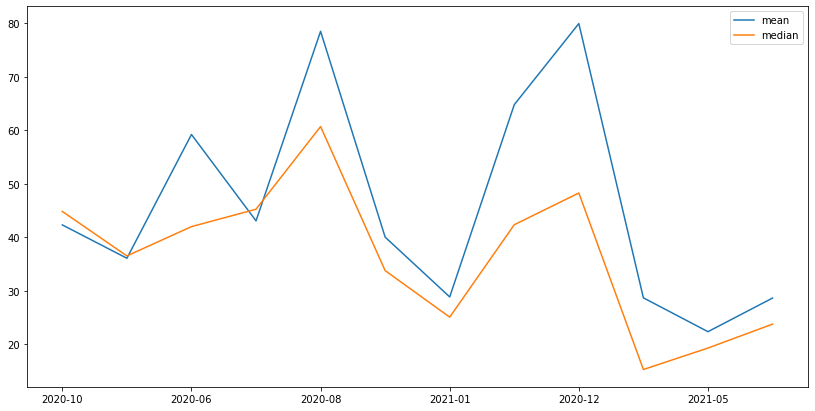

In [12]:
# changes in how many telekom people one obermedia person signifies over time
_ax = pd.DataFrame(
    {v: k["mean"].loc[:9].diff().agg(["mean", "median"]) for v, k in desc_dic.items()}
).T.plot(figsize=(14, 7))